In [3]:
import argparse
import gym
import matplotlib.pyplot as plt
import numpy as np
from itertools import count
from collections import deque
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical
from collections import namedtuple


### REINFORCE - NO BASELINE

In [ ]:

env = gym.make('CartPole-v1')
env.reset()
# torch.manual_seed(543)


class Policy(nn.Module):
    def __init__(self):
        super(Policy, self).__init__()
        self.affine1 = nn.Linear(4, 256)
        self.dropout = nn.Dropout(p=0.5)
        self.affine2 = nn.Linear(256, 2)

        self.saved_log_probs = []
        self.rewards = []

    def forward(self, x):
        x = self.affine1(x)
        x = self.dropout(x)
        x = F.relu(x)
        action_scores = self.affine2(x)
        return F.softmax(action_scores, dim=1)


policy = Policy()
optimizer = optim.Adam(policy.parameters(), lr=1e-2)
eps = np.finfo(np.float32).eps.item()


def select_action(state):
    state = torch.from_numpy(state).float().unsqueeze(0)
    probs = policy(state)
    m = Categorical(probs)
    action = m.sample()
    policy.saved_log_probs.append(m.log_prob(action))
    return action.item()


def finish_episode():
    gamma = 0.99
    R = 0
    policy_loss = []
    returns = deque()
    for r in policy.rewards[::-1]:
        R = r + gamma * R
        returns.appendleft(R)

    returns = torch.tensor(returns)
    returns = (returns - returns.mean()) / (returns.std() + eps)

    for log_prob, R in zip(policy.saved_log_probs, returns):
        policy_loss.append(-log_prob * R)
    optimizer.zero_grad()
    policy_loss = torch.cat(policy_loss).sum()
    policy_loss.backward()
    optimizer.step()
    del policy.rewards[:]
    del policy.saved_log_probs[:]


def train():
    running_reward = 10
    num_episodes = 600
    log_interval = 10
    ep_rew_history = np.zeros((num_episodes,))
    for i_episode in range(num_episodes):
        state = env.reset()
        ep_reward = 0
        for t in range(1, 10000):
            action = select_action(state)
            state, reward, done, _ = env.step(action)
            policy.rewards.append(reward)
            ep_reward += reward
            if done:
                break

        running_reward = 0.05 * ep_reward + (1 - 0.05) * running_reward
        ep_rew_history[i_episode] = ep_reward

        finish_episode()
    return ep_rew_history,running_reward

# train()



/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Completed run 1, obtained final running reward - 136.1136201979518
Completed run 2, obtained final running reward - 207.16140035817867
Completed run 3, obtained final running reward - 40.80429377167678
Completed run 4, obtained final running reward - 454.30452363791994
Completed run 5, obtained final running reward - 111.13668634643786


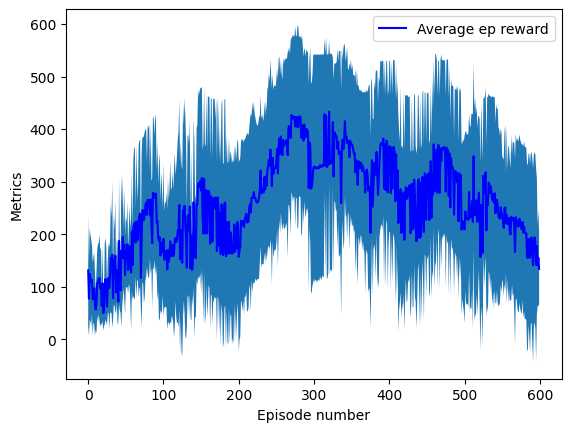

In [ ]:
num_episodes = 600
num_runs = 5

def runs():
    run_hist = np.zeros((num_runs, num_episodes))

    for i in range(num_runs):
      ep_hist, running_rew = train()
      print("Completed run {}, obtained final running reward - {}".format(i+1,running_rew))
      run_hist[i,:] = ep_hist.reshape((-1,))

    avg_run = np.mean(run_hist, axis=0)
    std_run = np.std(run_hist, axis=0)
    return avg_run, std_run

avg_run, std_run = runs()

plt.plot(avg_run, 'b-', label="Average ep reward")  
plt.fill_between(list(range(num_episodes)), avg_run + std_run, avg_run - std_run)
plt.xlabel("Episode number")
plt.ylabel("Metrics")
plt.legend()
plt.show()

### BASELINE

In [15]:

env = gym.make('CartPole-v1')
env.reset()
# torch.manual_seed()

SavedAction = namedtuple('SavedAction', ['log_prob', 'value'])

class BaselinePolicy(nn.Module):
    def __init__(self):
        super(BaselinePolicy, self).__init__()
        # shared network used to train
        self.affine1 = nn.Linear(4, 128)
        self.dropout = nn.Dropout(p=0.5)

        self.action_head = nn.Linear(128,2)
        self.value_head = nn.Linear(128, 1)

        self.saved_actions = []
        self.rewards = []

    def forward(self, x):
        x = self.affine1(x)
        x = self.dropout(x)
        x = F.relu(x)
        action_prob = F.softmax(self.action_head(x))
        state_values = self.value_head(x)
        return action_prob, state_values

eps = np.finfo(np.float32).eps.item()

def select_action(state,model):
    state = torch.from_numpy(state).float().unsqueeze(0)
    probs, state_value = model(state)
    m = Categorical(probs)
    action = m.sample()
    model.saved_actions.append(SavedAction(m.log_prob(action), state_value))
    return action.item()

def finish_episode_baseline(model,gamma,optimizer):
    R = 0
    saved_actions = model.saved_actions
    policy_losses = []
    value_losses = []
    returns = []

    for r in model.rewards[::-1]:
        R = r + gamma * R
        returns.insert(0, R)
    # returns will contain [G_t,......G_t+n] in order

    returns = torch.tensor(returns)
    returns = (returns - returns.mean()) / (returns.std() + eps)

    for (log_prob, value), R in zip(saved_actions, returns):

        with torch.no_grad(): advantage = R - value.item()
        policy_losses.append(-log_prob * advantage)
        value_losses.append(nn.MSELoss()(value, torch.tensor([R]))) # MSBE

    optimizer.zero_grad()

    loss = torch.stack(policy_losses).sum() + torch.stack(value_losses).sum()
    loss.backward()
    optimizer.step()

    # reset rewards and action buffer
    del model.rewards[:]
    del model.saved_actions[:]


def train_baseline(model,gamma,optimizer):
    running_reward = 10
    num_episodes = 600
    log_interval = 10
    ep_rew_history = np.zeros((num_episodes,))
    for i_episode in range(num_episodes):
        state = env.reset()
        ep_reward = 0
        for t in range(1, 10000):
            action = select_action(state,model)
            state, reward, done, _ = env.step(action)
            # if args.render:
            #     env.render()
            model.rewards.append(reward)
            ep_reward += reward
            if done:
                break

        running_reward = 0.05 * ep_reward + (1 - 0.05) * running_reward
        ep_rew_history[i_episode] = ep_reward

        finish_episode_baseline(model,gamma,optimizer)
        # if i_episode % log_interval == 0:
        #     print('Episode {}\tLast reward: {:.2f}\tAverage reward: {:.2f}'.format(
        #           i_episode, ep_reward, running_reward))
        # if running_reward > env.spec.reward_threshold:
        #     print("Solved! Running reward is now {}, achieved in {} episodes and "
        #           "the last episode runs to {} time steps!".format(running_reward, i_episode, t))
        #     break

    return ep_rew_history,running_reward

# a,b = train()



/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


<ipython-input-15-84b782b3fc09>:24: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  action_prob = F.softmax(self.action_head(x))


Completed run 1, obtained final running reward - 279.95699189047644
Completed run 2, obtained final running reward - 498.9683041395321
Completed run 3, obtained final running reward - 494.6225729412702
Completed run 4, obtained final running reward - 428.267057939233
Completed run 5, obtained final running reward - 494.2729701906961


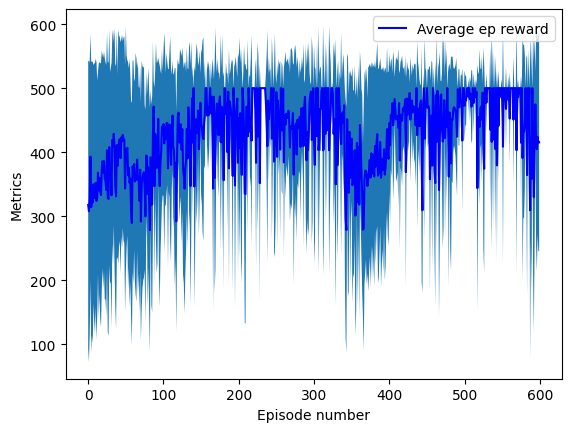

In [17]:
num_episodes = 600
num_runs = 5

def runs_baseline():
    model = BaselinePolicy()
    optimizer = optim.Adam(model.parameters(), lr=1e-2)

    run_hist = np.zeros((num_runs, num_episodes))
    gamma = 0.99

    for i in range(num_runs):
      ep_hist, running_rew = train_baseline(model,gamma,optimizer)
      print("Completed run {}, obtained final running reward - {}".format(i+1,running_rew))
      run_hist[i,:] = ep_hist.reshape((-1,))

    avg_run = np.mean(run_hist, axis=0)
    std_run = np.std(run_hist, axis=0)
    return avg_run, std_run

avg_run_b, std_run_b = runs_baseline()

plt.plot(avg_run_b, 'b-', label="Average ep reward")
plt.fill_between(list(range(num_episodes)), avg_run_b + std_run_b, avg_run_b - std_run_b)
plt.xlabel("Episode number")
plt.ylabel("Metrics")
plt.legend()
plt.show()